In [5]:
import pandas as pd
import matplotlib as plt

df = pd.read_csv("logs5.csv.gz", parse_dates=[1])

In [6]:
len(df)

8267891

In [7]:
df.dtypes

ogpweb#               int64
date         datetime64[ns]
request              object
code                  int64
bytes                 int64
referrer             object
useragent            object
source               object
rt                  float64
urt                 float64
dtype: object

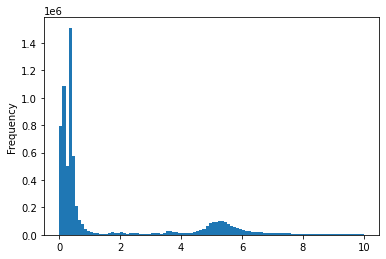

In [8]:
ax = df['urt'].plot.hist(bins=100, range=[0,10])

# Processing time per page

In [9]:
def bucket(r):
    r = r.rsplit('HTTP/')[0].split('GET ')[-1]
    for s in ('?', '/dataset/', '/reference/', '/inventory/',
              '/comment/', '/node/', '/suggested-datasets/',
              '/4plan/', '/apps/'):
        if s in r:
            r = r.split(s)[0] + s + '…'
    return r
bdf = df[['request','urt']].copy(deep=True)
bdf['request'] = bdf['request'].map(bucket)

In [10]:
sdf = bdf.groupby(['request']).agg(['median','count','sum'])
sdf.columns = sdf.columns.map('_'.join)
sdf['urt_sum'] = sdf['urt_sum'] / (60*60*24)  # days

busy = sdf[(sdf['urt_count'] > 10) & (sdf['urt_sum'] > 0.02)]
busy.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (days)'})

,urt_median,urt_count,urt_sum (days)
request,,,
/fr/search/contrats?…,5.1280,1655210,73.847018
/en/search/contracts?…,5.2030,246337,16.977726
/fr/search/hospitalityq?…,5.1430,130834,8.552058
/data/en/dataset?…,0.3850,1732365,7.874135
/fr/search/travelq?…,5.2670,109895,7.524908
/fr/search/ati?…,3.7240,130217,6.254757
/en/search/ati?…,3.0450,109618,2.636588
/fr/search/reclassification?…,4.9120,21400,1.346281
/en/external-comment/dataset/…,0.7410,109534,1.065349


In [11]:
urt_sum_sum = sdf['urt_sum'].sum()
urt_sum_sum # total processing time in days

140.53427667826762

In [12]:
dsearch_sum = bdf[bdf['request'].str.contains('/search/')]['urt'].sum() / (60*60*24) # days
print("%0.2f days processing drupal search" % (dsearch_sum))
print("%0.2f %% urt" % (dsearch_sum / urt_sum_sum * 100))

121.13 days processing drupal search
86.19 % urt


# Requests vs processing time per app

In [13]:
df['search'] = df['urt'].notna() & df['request'].str.contains(r'/(?:od|bn|ct|ei|gc|nap|si|qp|sd)/')
df['ckan'] = df['urt'].notna() & df['request'].str.contains(' /data/')
df['drupal'] = df['urt'].notna() & ~ df['search'] & ~ df['ckan']

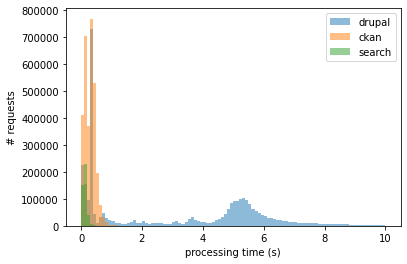

In [14]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['urt'], alpha=0.5, bins=100, range=[0,10],  label='drupal')
ax.hist(df[df['ckan']]['urt'], alpha=0.5, bins=100, range=[0,10],  label='ckan')
ax.hist(df[df['search']]['urt'], alpha=0.5, bins=100, range=[0,10], label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests')
ax.set_xlabel('processing time (s)')
plt.show()

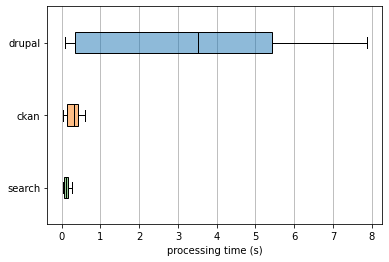

In [15]:
fig, ax = plt.subplots()
bp = ax.boxplot(
    [df[df['search']]['urt'],
     df[df['ckan']]['urt'],
     df[df['drupal']]['urt']],
    labels=['search', 'ckan', 'drupal'],
    showfliers=False,
    vert=False,
    patch_artist=True,
    whis=(5,95),
    medianprops={'color':'black'}
)
bp['boxes'][0].set_facecolor('#2ca02c80')
bp['boxes'][1].set_facecolor('#ff7f0e80')
bp['boxes'][2].set_facecolor('#1f77b480')
ax.set_xlabel('processing time (s)')
ax.xaxis.grid(True)
plt.show()

# Processing time per CKAN API call

In [16]:
cadf = df[df['request'].str.contains('/action/')][
    ['request','urt']].copy(deep=True)
cadf['request'] = cadf['request'].str.extract(r'/action/(\w+)')

In [17]:
scadf = cadf.groupby(['request']).agg(['median','count','sum'])
scadf.columns = scadf.columns.map('_'.join)
scadf['urt_sum'] = scadf['urt_sum'] / 60  # minutes
scadf.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (minutes)'})

,urt_median,urt_count,urt_sum (minutes)
request,,,
package_update,5.4310,7224,667.672183
package_show,0.0380,269103,189.949033
package_search,0.1300,5551,37.540450
organization_list,6.0750,221,22.618517
package_create,4.0070,14,1.063617
package_list,1.4815,22,0.606817
recently_changed_packages_activity_list,0.1725,62,0.196000
package_delete,0.7840,3,0.030817
help_show,0.0140,5,0.001217


# Cache simulation

In [18]:
import heapq
from datetime import datetime, timedelta

def csim(expire):
    h = []
    c = set()
    def lookup(row):
        dt = row['date']
        req = row['request']
        while h and h[0][0] + expire < dt:
            c.remove(h[0][1])
            heapq.heappop(h)
        if req in c:
            return True
        heapq.heappush(h, (dt, req))
        c.add(req)
        return False
    return lookup

In [19]:
cdf = df[df['urt'].notna() & df['request'].str.match('GET ')][
    ['ogpweb#','date','request','urt']].copy(deep=True)
cdf.sort_values(by='date', inplace=True)

In [20]:
cdf['1dhit'] = cdf.apply(csim(timedelta(days=1)), axis=1)

In [21]:
s1d = cdf[cdf['1dhit']][['urt']].sum()
print("%0.2f hours saved with 1d cache" % (s1d / 60 / 60))
print("%0.2f %% savings" % (s1d / 60 / 60 / 24 / urt_sum_sum * 100))

131.92 hours saved with 1d cache
3.91 % savings


In [22]:
cdf['1hhit'] = cdf.apply(csim(timedelta(hours=1)), axis=1)

In [23]:
s1h = cdf[cdf['1hhit']][['urt']].sum()
print("%0.2f hours saved with 1h cache" % (s1h / 60 / 60))
print("%0.2f %% savings" % (s1h / 60 / 60 / 24 / urt_sum_sum * 100))

55.11 hours saved with 1h cache
1.63 % savings


In [24]:
cdf['5mhit'] = cdf.apply(csim(timedelta(minutes=5)), axis=1)

In [25]:
s5m = cdf[cdf['5mhit']][['urt']].sum()
print("%0.2f hours saved with 5m cache" % (s5m / 60 / 60))
print("%0.2f %% savings" % (s5m / 60 / 60 / 24 / urt_sum_sum * 100))

25.68 hours saved with 5m cache
0.76 % savings


# Bots

In [26]:
agents = df[['useragent', 'urt']].groupby(['useragent']).count()
agents.sort_values('urt', ascending=False)[:20].rename(
    columns={'urt':'# requests'})

,# requests
useragent,
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1),388389
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm),309148
Mozilla/5.0 (compatible; SemrushBot/6~bl; +http://www.semrush.com/bot.html),264701
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html),263505
Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1),194639
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; TencentTraveler 4.0),194427
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0,194375
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; The World),194130
"Mozilla/5.0 (Windows; U; Windows NT 6.1; en-us) AppleWebKit/534.50 (KHTML, like Gecko) Version/5.1 Safari/534.50",194079


In [27]:
import re
df['bot'] = df['useragent'].str.extract(
    r'(aolbuild|baidu|bingbot|bingpreview|msnbot|duckduckgo'
    r'|adsbot-google|googlebot|mediapartners-google|teoma|slurp'
    r'|yandexbot|barkrowler|ccbot|csnibot|petalbot|sogou|applebot'
    r'|semrushbot|megaindex|siteimprove|ahrefsbot|tencenttraveler'
    r'|riddler|dotbot)', flags=re.IGNORECASE)

In [28]:
bots = df[df['bot'].notna()][['bot', 'urt']].copy()
bots['bot'] = bots['bot'].str.lower()
bots['urt'] = bots['urt'] / (60*60*24) # days
bots.groupby(['bot']).sum().sort_values('urt', ascending=False).rename(
    columns={'urt':'urt (days)'})

,urt (days)
bot,
tencenttraveler,6.485480
googlebot,2.969361
bingbot,1.284416
petalbot,0.942348
semrushbot,0.556291
ahrefsbot,0.530217
dotbot,0.340838
siteimprove,0.242929
applebot,0.211488


In [29]:
bot_sum = bots['urt'].sum()
print("%0.2f days processing bot traffic" % (bot_sum))
print("%0.2f %% urt" % (bot_sum / urt_sum_sum * 100))

13.95 days processing bot traffic
9.92 % urt


# Requests vs date per app

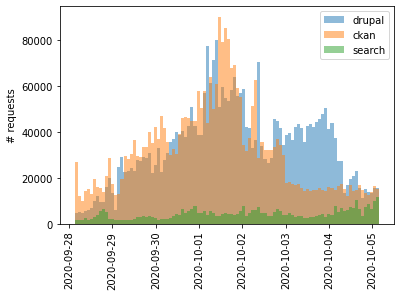

In [30]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['date'], alpha=0.5, bins=100, label='drupal')
ax.hist(df[df['ckan']]['date'], alpha=0.5, bins=100, label='ckan')
ax.hist(df[df['search']]['date'], alpha=0.5, bins=100, label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests')
plt.xticks(rotation=90)
plt.show()

# Potential Optimization Impact

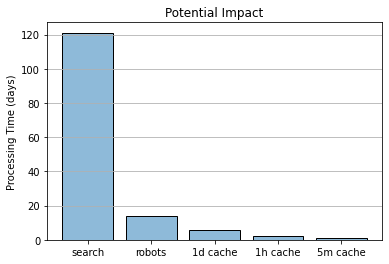

In [32]:
objects = ('search', 'robots', '1d cache', '1h cache', '5m cache')
y_pos = range(len(objects))
performance = [dsearch_sum, bot_sum, s1d/60/60/24, s1h/60/60/24, s5m/60/60/24]

plt.bar(y_pos, performance, align='center', facecolor='#1f77b480', edgecolor='black')
plt.xticks(y_pos, objects)
plt.ylabel('Processing Time (days)')
plt.title('Potential Impact')
plt.grid(axis='y')
plt.show()

# Agents targeting Drupal search

In [35]:
agents = df[['useragent']].copy()
agents['/search/'] = df['request'].str.contains('/search/')
agents = agents.groupby(['useragent']).agg(['count','sum'])
agents.columns = agents.columns.map('_'.join)
agents.sort_values('/search/_sum', ascending=False).rename(
    columns={'/search/_count': 'all hits', '/search/_sum': 'drupal search'})[:30]


,all hits,drupal search
useragent,,
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1),390028,250336.0
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0),194644,125615.0
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_0) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.56 Safari/535.11",194831,125560.0
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Maxthon 2.0),194817,125375.0
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0,195249,125240.0
Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/20100101 Firefox/4.0.1,194463,125135.0
Opera/9.80 (Windows NT 6.1; U; en) Presto/2.8.131 Version/11.11,194521,125134.0
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Avant Browser),194860,125078.0
Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; TencentTraveler 4.0),195297,125067.0


In [38]:
ruby = df[(df['useragent'] == 'Ruby') & df['request'].str.contains('/search/')].copy()
ruby['ip'] = ruby['source'].str.extract(r'(.+):')
len(ruby[['ip', 'useragent']].groupby('ip').count())
# spread across IP addresses with even multiples of 54 requests from each (not shown)

852